# Imports

In [216]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import h5py

import pandas as pd
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from openTSNE import TSNE as opTSNE

from skimage.color import lab2rgb

import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans




from sklearn.mixture import GaussianMixture 
# from lifelines import KaplanMeierFitter

import copy
import time



# Functions

In [217]:
def SampleZoomIn(SampleID , PixelSampleID ,padding_factor = 1):
    specific_index = SampleID
    mask = (PixelSampleID == specific_index) 
    label_indices = np.where(mask == True)

    zoomed_height_max = max(label_indices[0]) + padding_factor
    zoomed_height_min = min(label_indices[0]) - padding_factor
    zoomed_width_max = max(label_indices[1]) + padding_factor
    zoomed_width_min = min(label_indices[1]) - padding_factor

    if zoomed_height_max > height:
        zoomed_height_max= height

    if zoomed_height_min < 0:
        zoomed_height_min= 0

    if zoomed_width_max > width:
        zoomed_width_max= width

    if zoomed_width_min < 0:
        zoomed_width_min= 0
        
    return zoomed_height_max , zoomed_height_min , zoomed_width_max, zoomed_width_min

In [218]:
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [219]:
def CreateColorMap(NumberofColors , colorsArray ):
    cmap = LinearSegmentedColormap.from_list('cmap', colorsArray, N=NumberofColors)
    return cmap

In [220]:
def CreateColorMap_Continuous(NumberofColors , colorsArray ):
    cvals = np.arange(0,NumberofColors-1)
    colors = colorsArray
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    
    return cmap

# Reading Breast Data

In [221]:
h5 = h5py.File('breastData.mat', 'r')


HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube = h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID = h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  
print(list(h5.keys()))
z = h5.get('z')[:]
print(z)
h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')
height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 
indices_of_background = np.where(flattened_pixel_to_sample_ID == -1)
sample_only_data = np.delete(flattened_MSI_data_cube, indices_of_background[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_of_background[0] , axis=0)
# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
sample_only_scaled_data = scaler.fit_transform(sample_only_data) 


['#refs#', '#subsystem#', 'Clinical_data', 'HE_image', 'MSI_data_cube', 'goodlist', 'peak_list', 'pixel_to_sample_ID', 'x', 'y', 'z']
[[62.]]


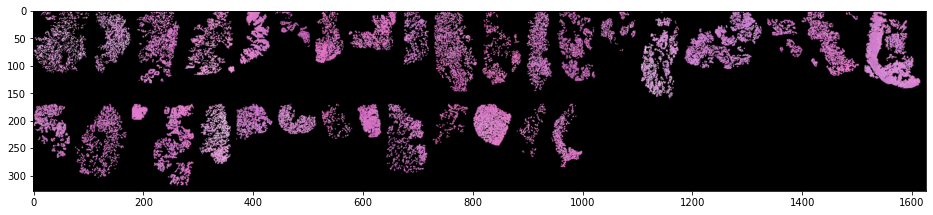

In [222]:
plt.figure(figsize=(16,10))
plt.imshow(HE_image)
plt.show()

# PCA 

In [223]:
pca = PCA(n_components=8)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.17345186 0.105074   0.06409271 0.05961361 0.05411838 0.04949253
 0.04291918 0.03652938]


In [224]:
sample_only_scaled_data.shape

(48426, 62)

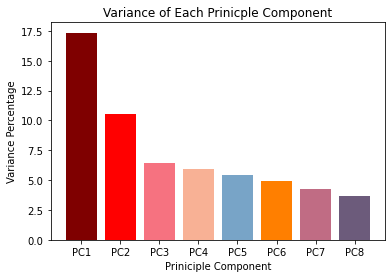

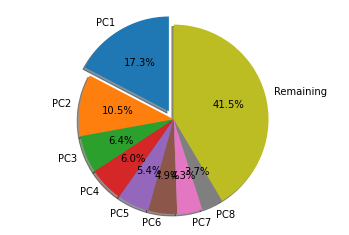

Variance Represented by PCA = 58.53 %


In [225]:
PCA=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"]

COLORS =["#7f0000","#ff0000","#F67280","#F8B195", "#78a4c7","#ff7f00","#C06C84","#6C5B7B" ]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

# Pie chart
labels = "PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8", "Remaining"
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] ,variance[5],variance[6],variance[7] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] +variance[5]+variance[6]+variance[7]) ]
explode = (0.1, 0, 0, 0, 0, 0,0,0,0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4]+variance[5]+variance[6]+variance[7])*100 , 2) ) +' %')

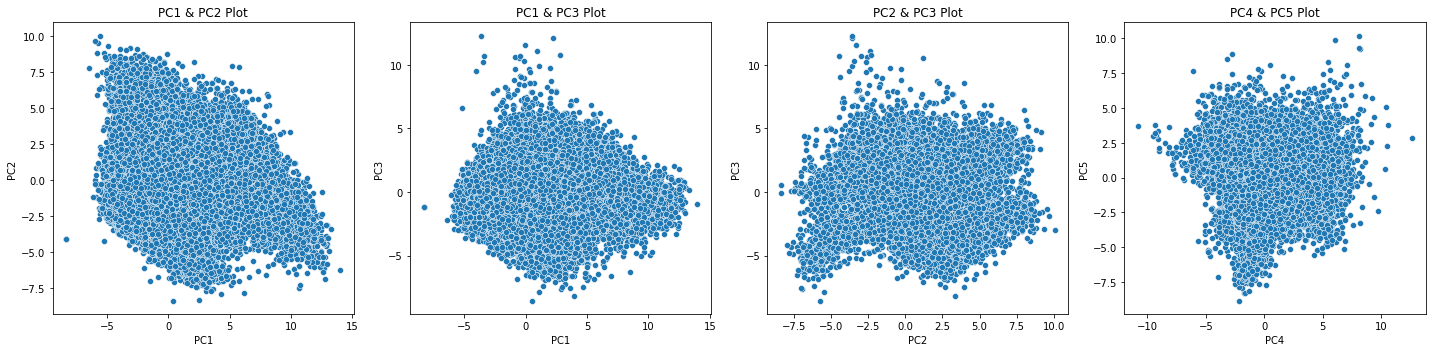

Text(0.5, 0.92, 'PCA 3D')

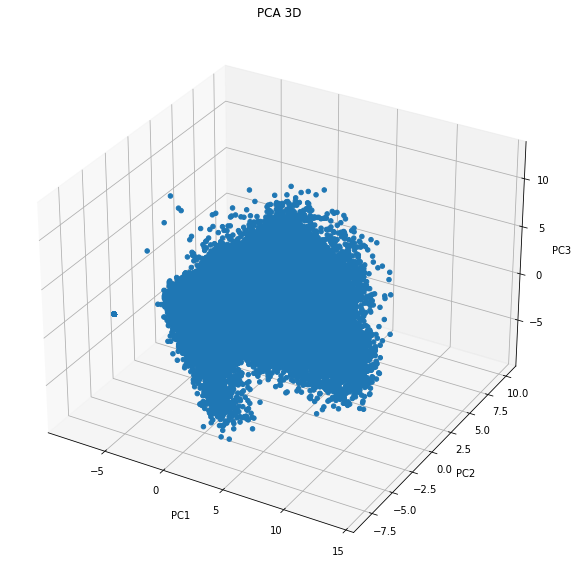

In [226]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")
sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")
sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

# TSNE

In [227]:
# Old Breast Cancer TSNE Settings
'''
time_start = time.time()
tsne = opTSNE(
    n_components = 3,
    perplexity = 500,
    learning_rate = 200,
    initialization  = 'random',
    random_state = 0,
    early_exaggeration = 12,
    n_iter = 1000,
    theta = 0.5,
    early_exaggeration_iter = 250,
    metric="euclidean",
    negative_gradient_method = 'barnes-hut',
    verbose=True,
)
%time tsne_results_op = tsne.fit(sample_only_scaled_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

'\ntime_start = time.time()\ntsne = opTSNE(\n    n_components = 3,\n    perplexity = 500,\n    learning_rate = 200,\n    initialization  = \'random\',\n    random_state = 0,\n    early_exaggeration = 12,\n    n_iter = 1000,\n    theta = 0.5,\n    early_exaggeration_iter = 250,\n    metric="euclidean",\n    negative_gradient_method = \'barnes-hut\',\n    verbose=True,\n)\n%time tsne_results_op = tsne.fit(sample_only_scaled_data)\n\nprint(\'t-SNE done! Time elapsed: {} seconds\'.format(time.time()-time_start))\n'

In [228]:
#np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results_op)

In [229]:
# tSNE Model , Run once and save results in numpy array to be used later
'''
time_start = time.time()
tsne_results_op = TSNE(n_components=3,
            perplexity = 50,
            learning_rate = 200,
            init = 'random',
            random_state = 0,
            early_exaggeration = 12,
            n_iter = 1000,
            verbose=True,
            ).fit_transform(sample_only_scaled_data)



print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

'''




[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 48426 samples in 0.006s...
[t-SNE] Computed neighbors for 48426 samples in 55.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48426
[t-SNE] Computed conditional probabilities for sample 2000 / 48426
[t-SNE] Computed conditional probabilities for sample 3000 / 48426
[t-SNE] Computed conditional probabilities for sample 4000 / 48426
[t-SNE] Computed conditional probabilities for sample 5000 / 48426
[t-SNE] Computed conditional probabilities for sample 6000 / 48426
[t-SNE] Computed conditional probabilities for sample 7000 / 48426
[t-SNE] Computed conditional probabilities for sample 8000 / 48426
[t-SNE] Computed conditional probabilities for sample 9000 / 48426
[t-SNE] Computed conditional probabilities for sample 10000 / 48426
[t-SNE] Computed conditional probabilities for sample 11000 / 48426
[t-SNE] Computed conditional probabilities for sample 12000 / 48426
[t-SNE] Computed conditional probabilities for s

In [276]:
#np.save('tSNE_Breast_Results_default_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results_op)

tsne_results_op = np.load("tSNE_Breast_Results_default_Time_2366.2736546993256_seconds.npy")

In [231]:
tsne_df = pd.DataFrame(data=tsne_results_op[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = sample_ID_pixels
tsne_df['L_Component'] = tsne_results_op[:,0]
tsne_df['A_Component'] = tsne_results_op[:,1]
tsne_df['B_Component'] = tsne_results_op[:,2]

In [232]:
LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A, B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)

C:\Users\omars\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2190 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


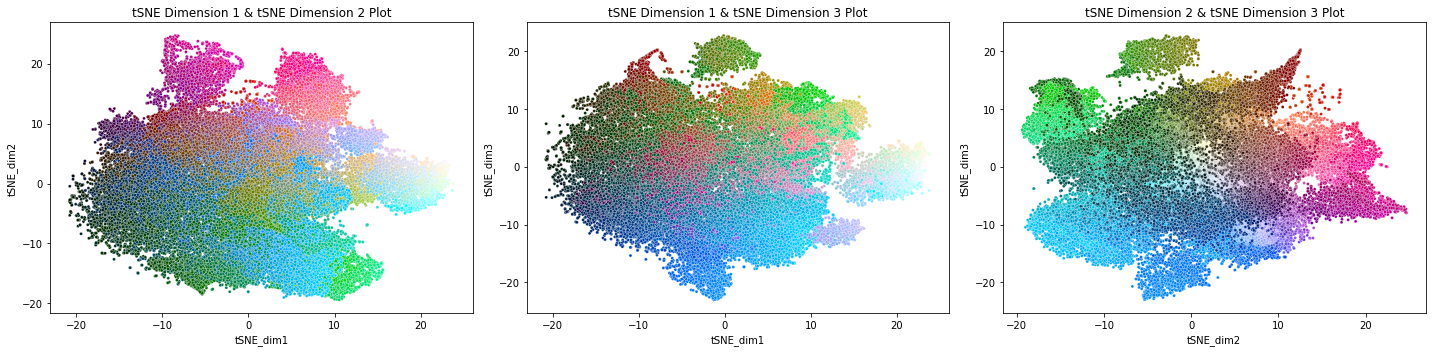

In [233]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()


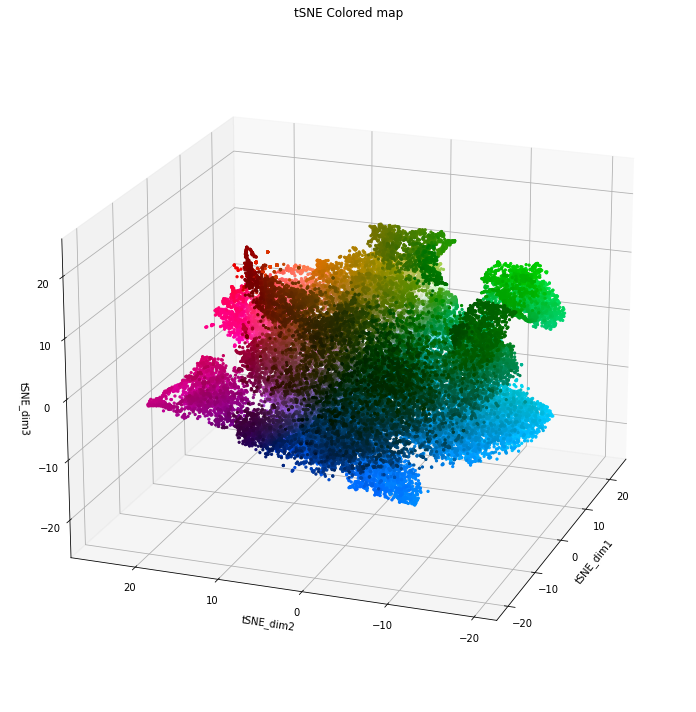

In [234]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'],
    zs= tsne_df['tSNE_dim3'],
    c = RGB_colors,
    s = 5,
    alpha = 1,
)
# ax.set_xlim(-40,40)
# ax.set_ylim(-40,40)
# ax.set_zlim(-40,40)
ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


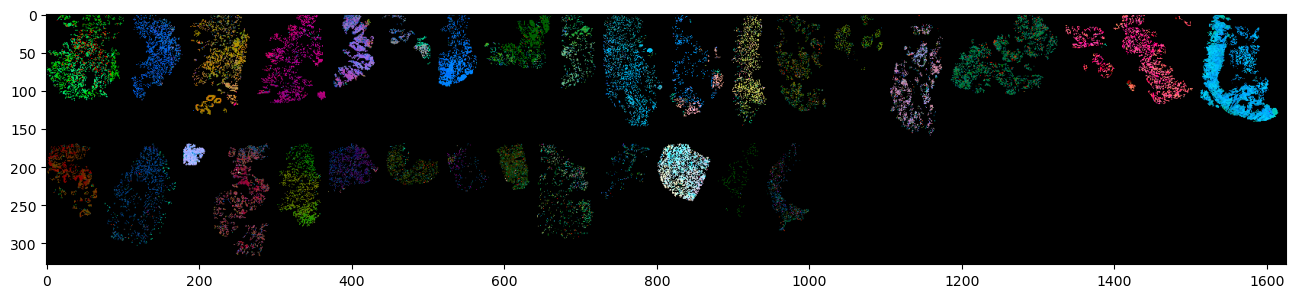

In [235]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=100)
plt.imshow(tsne_image)


# Kmeans 

In [236]:
kmeans = KMeans(n_clusters=8, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_7 = KMeans(n_clusters=7, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_6 = KMeans(n_clusters=6, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)

#kmeans_9 = KMeans(n_clusters=9, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)



In [237]:
indices_edit = np.where(pixel_to_sample_ID != -1)
KMeans_image = np.full( (height,width),-1 )
KMeans_image_6 = np.full( (height,width),-1 )
KMeans_image_7 = np.full( (height,width),-1 )

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image[i][j] = kmeans.labels_[increment]
    
    increment += 1

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_6[i][j] = kmeans_6.labels_[increment]
    
    increment += 1
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_7[i][j] = kmeans_7.labels_[increment]
    
    increment += 1

# Gaussian Mixture Model

In [238]:
gmm = GaussianMixture(n_components=8,
                      max_iter=1500,
                      n_init=10,
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(tsne_results_op)


In [239]:
indices_edit = np.where(pixel_to_sample_ID != -1)
gaussian_image = np.full((height, width), -1)

increment = 0
for i, j in zip(indices_edit[0], indices_edit[1]):
    gaussian_image[i][j] = gmm[increment]
    increment += 1


# Whole image Results

In [240]:
# colorsarray = [ "black" , "royalblue" , , "aqua" , "orangered" , "yellow",,"sandybrown","red" ] 
# colorsarray=["black","#80B1D3","#FF7F0E","#2CA02C","#B5CF6B","#9467BD","#E7CB94","#BCBD22","#FFD92F"]
# colorsarray=['#000000','powderblue','magenta', 'teal', 'yellow', 'blue', 'orange',"lime","crimson"]
# colorsarray8 = [ "black" , "magenta" , "#007fff", "#00ffff" , "#7fff7f" , "#ffff00","#ff7f00","#ff0000","#7f0000" ]
colorarray8=[ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000","#ff7f00"]
colorsarray7 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000"]
colorsarray6 = [ "black","olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo"]
colorsarrayTSNE = ["olivedrab","gold","darkturquoise", "wheat","fuchsia","indigo","#7f0000","#ff7f00"]

cmap8 = CreateColorMap(9,colorarray8)
cmapTSNE= CreateColorMap(8,colorsarrayTSNE)

cmap7 = CreateColorMap(8,colorsarray7)
cmap6 = CreateColorMap(7,colorsarray6)

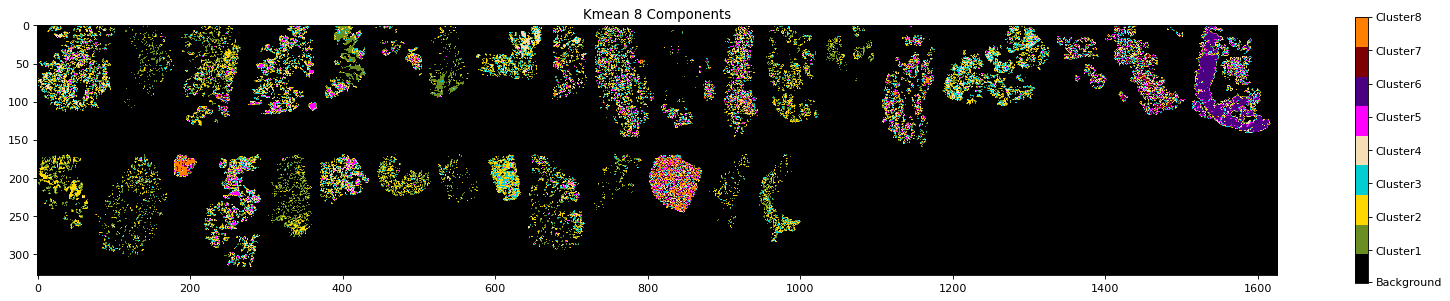

In [241]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 8 Components")
plt.imshow(KMeans_image, cmap=cmap8)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5","Cluster6","Cluster7","Cluster8"])


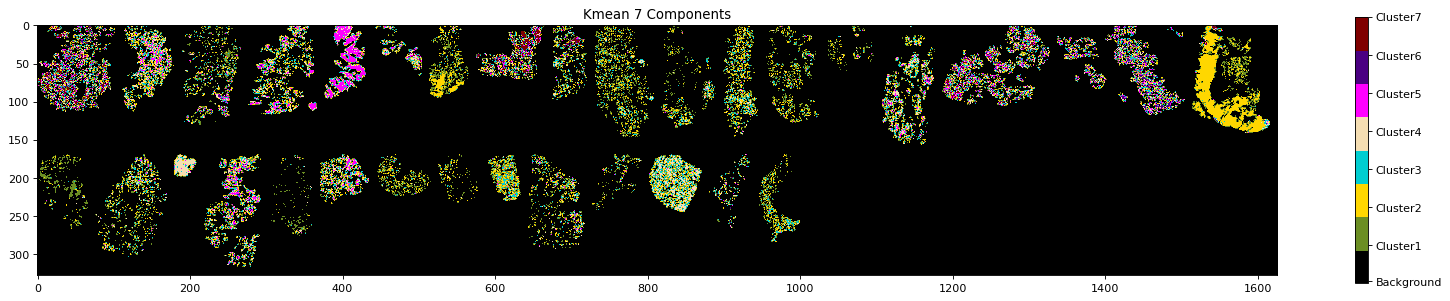

In [242]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 7 Components")
plt.imshow(KMeans_image_7, cmap=cmap7)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5","Cluster6","Cluster7"])

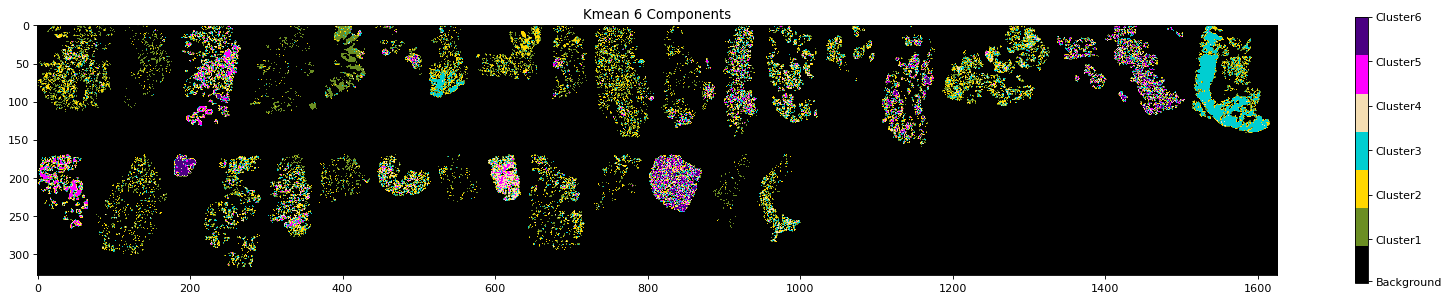

In [243]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 6 Components")
plt.imshow(KMeans_image_6, cmap=cmap6)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5","Cluster6"])

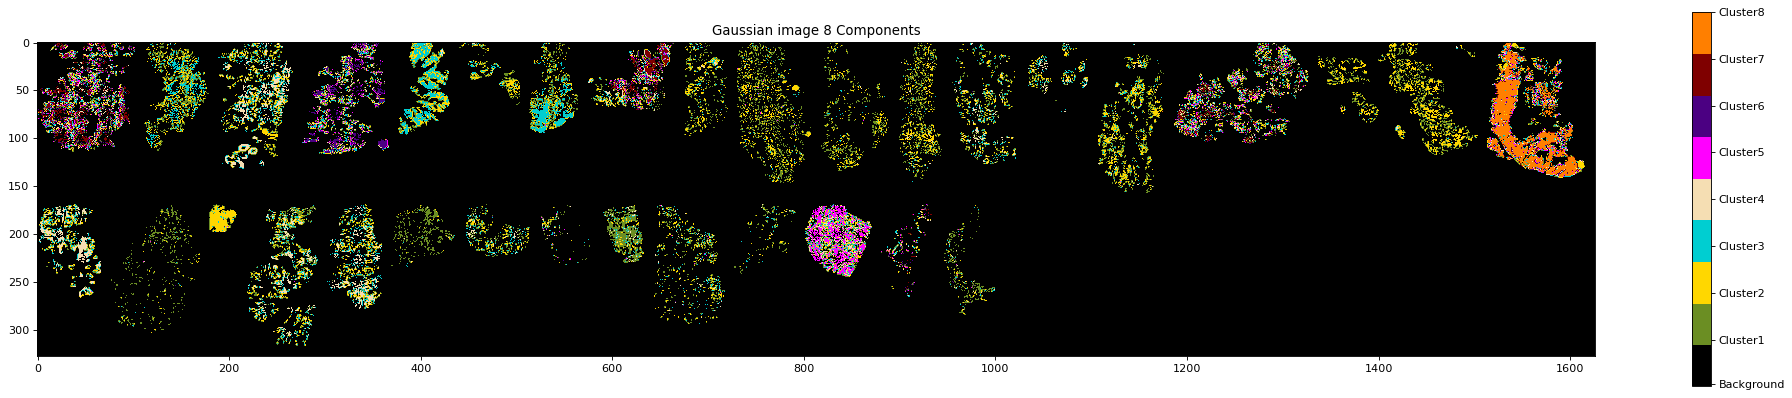

In [244]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Gaussian image 8 Components")
plt.imshow(gaussian_image, cmap=cmap8)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])



plt.tight_layout()
plt.show()

# Zoomedin image Results

In [245]:
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 21, PixelSampleID = pixel_to_sample_ID , padding_factor = 2)
#7
zoomedIn_image= KMeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


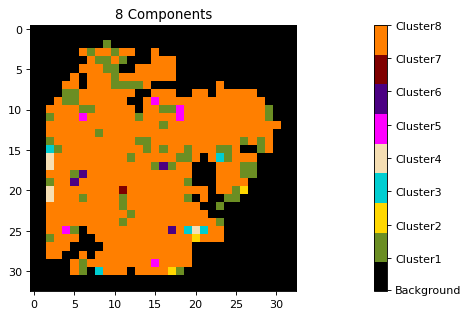

In [246]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("8 Components")
labels = np.array(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])

'''
unique_cluster_labels = np.unique(zoomedIn_image)
colorarray8_np = np.array(colorarray8)
zoomedin_cmap = CreateColorMap(len(unique_cluster_labels) , colorarray8_np[unique_cluster_labels+1])

x = np.arange(-1,len(unique_cluster_labels))
iterations = len(x) - len(unique_cluster_labels)
for i in range(iterations):
    x = np.delete(x, -1)
print(x)

plt.imshow(zoomedIn_image, cmap=zoomedin_cmap)
colorbar = plt.colorbar()
colorbar.set_ticks(x)
colorbar.set_ticklabels(labels[unique_cluster_labels+1])
'''

plt.imshow(zoomedIn_image, cmap=cmap8)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])


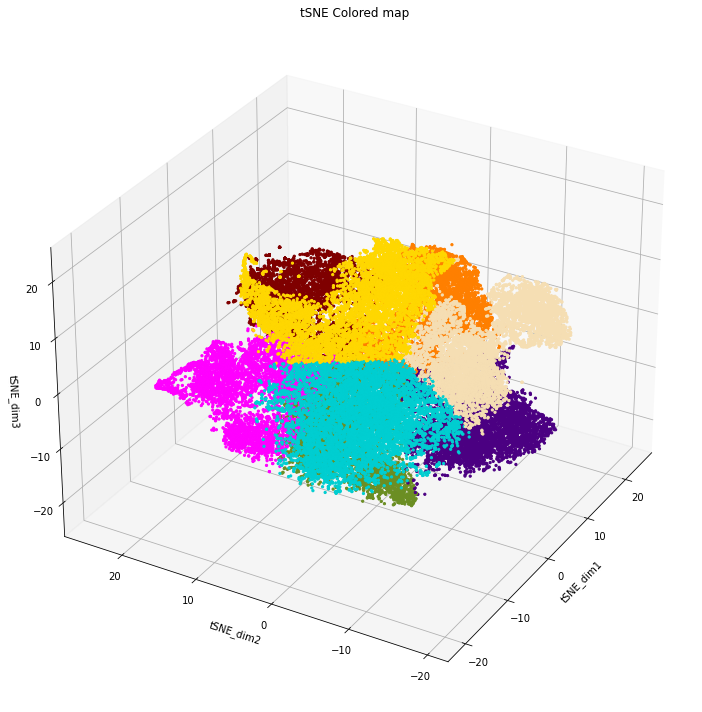

In [247]:
colors = ["#16235A","#F28A30","#888C46"]
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans.labels_,
    cmap = cmapTSNE,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Colored map")


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

# Metastasis Analysis

In [248]:
Clinical_data = pd.read_excel('ClinicalData.xlsx',"Breast Cancer Clinical Data")
# print(Clinical_data["pN"])

In [249]:
def metastasis_status(labels, Clinical_data, sample_ID_pixels=sample_ID_pixels):

    Clinical_data_copied = Clinical_data.copy(deep=True)
    labels_count = len(np.unique(labels))
    Clusters = [[] for _ in range(labels_count)]

    for i in range(1,len(Clinical_data)+1):
        Pixels_Samples = np.where(sample_ID_pixels == i)[0]
        Patient_Labels = labels[Pixels_Samples]

        for cluster_label in range(labels_count):
            Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]
            if len(Patient_Pixels) >= int((1/labels_count * len(Patient_Labels))):
                
                Clusters[cluster_label].append(i)

    NonMetastasis_Clusters = [[] for _ in range(labels_count)]
    Metastasis_Clusters = [[] for _ in range(labels_count)]
    Metastasis_IDs = [[] for _ in range(labels_count)]

    for patient_id in range(1, len(Clinical_data)+1):
        for j in range(labels_count):
            if (patient_id in Clusters[j]):
                if Clinical_data["pN"][patient_id-1] == 1:
                    NonMetastasis_Clusters[j].append(1)
                elif Clinical_data["pN"][patient_id-1] == 2:
                    Metastasis_Clusters[j].append(1)
                    Metastasis_IDs[j].append(patient_id)



    return NonMetastasis_Clusters, Metastasis_Clusters



In [250]:
def plot_metastasis_status(state0, state1):
   ind = len(state0)
   status0 = np.zeros(ind)
   status1 = np.zeros(ind)
   cluster_numbers = []
   for i in range(1, ind+1):
      cluster_numbers.append(str(i))
      

   for i in range(len(state0)):
      status0[i] = len(state0[i])
   for i in range(len(state1)):
      status1[i] = len(state1[i])
   print("NonMetastasis: " + str(status0))
   print("Metastasis: " + str(status1))

   plt.bar(cluster_numbers, status0, color="#d4d0c8")
   plt.bar(cluster_numbers, status1, bottom=status0, color="black")
   plt.xticks(cluster_numbers)
   plt.xlabel("Cluster numbers")
   plt.ylabel("Number of patients")
   plt.title("Metastasis Analysis of {} Clusters".format(ind))
   colors = {'pN0': '#d4d0c8', 'pN1': 'black'}
   labels = list(colors.keys())
   handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label])
              for label in labels]
   plt.legend(handles, labels)

   plt.show()


NonMetastasis: [6. 1. 0. 4. 2. 1. 2. 4.]
Metastasis: [ 2.  6. 12.  4.  3.  1.  3.  5.]


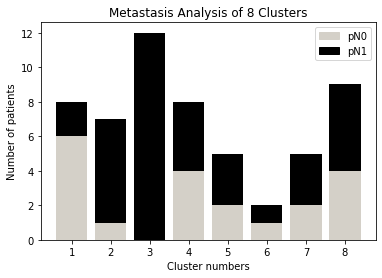

NonMetastasis: [1. 3. 0. 4. 4. 2. 4.]
Metastasis: [ 6.  1. 12.  5.  5.  3.  3.]


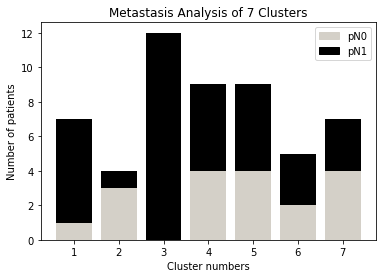

NonMetastasis: [4. 4. 3. 0. 1. 3.]
Metastasis: [ 5.  5.  1. 11.  7.  5.]


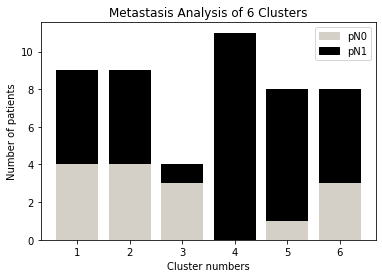

In [251]:
# Returns Non-Metastasis and Metastasis clusters
state08, state18 = metastasis_status(kmeans.labels_, Clinical_data)
state07, state17 = metastasis_status(kmeans_7.labels_, Clinical_data)
state06, state16 = metastasis_status(kmeans_6.labels_, Clinical_data)
# gmm08,gmm18=metastasis_status(gmm,Clinical_data)
#state09,state19=metastasis_status(kmeans_9.labels_,Clinical_data)

# Plots bar plot of Non-Metastasis and Metastasis clusters
plot_metastasis_status(state08, state18)
plot_metastasis_status(state07, state17)
plot_metastasis_status(state06, state16)
# plot_metastasis_status(gmm08,gmm18)
#plot_metastasis_status(state09,state19)


## Fischer Exact Test


# SAM

In [264]:
labels= kmeans.labels_
labels_count=len(np.unique(kmeans.labels_))
indices_of_patients = [[] for _ in range(len(Clinical_data))]
Sig_Cluster=[[] for _ in range(len(Clinical_data))]
Status=[[] for _ in range(len(Clinical_data))]

for i in range(1,len(Clinical_data)+1):
    Pixels_Samples = np.where(sample_ID_pixels == i)[0]
    Patient_Labels = labels[Pixels_Samples]
    
    for cluster_label in range(labels_count):

        Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]

        if len(Patient_Pixels) >= int((1/labels_count * len(Patient_Labels))):

            if cluster_label != 2:
                Status[i-1].append(1)
            else:
                Status[i-1].append(2)  

            Sig_Cluster[i-1].append(cluster_label)

    for j in range(0,len(Sig_Cluster[i-1])):
        
        indices=np.where(labels == Sig_Cluster[i-1][j])[0]

        #for element in indices:
        #    if element in Pixels_Samples:
                
        #        indices_of_patients[i-1].append(element)

        indices_of_patients[i-1].extend(list(set(Pixels_Samples).intersection(indices)))


In [265]:
Sig_Cluster

[[3, 6],
 [0],
 [1, 6],
 [4],
 [0, 4],
 [0, 3, 7],
 [0],
 [3],
 [3, 7],
 [0, 5, 7],
 [0, 7],
 [7],
 [1, 2],
 [1, 2],
 [2, 6, 7],
 [2, 3],
 [6],
 [5],
 [1],
 [0, 2],
 [7],
 [2, 4, 6],
 [1],
 [4],
 [1, 2],
 [2, 4],
 [1, 2],
 [2, 3, 7],
 [0, 2, 3],
 [7],
 [3],
 [2]]

In [266]:
Final_Status=[]
for patient in Status:
    if 2 in patient:
        Final_Status.append(2)
    else:
        Final_Status.append(1)

In [267]:
Unique_IDs = list(range(1,len(Clinical_data)+1))
Metastasis_Patients = [ ]
Average_protein_values = [ ]

for i in range(0,len(Unique_IDs)):
    Patient_MSI_values = sample_only_data[indices_of_patients[i]]
    Metastasis_Patients.append(Patient_MSI_values)
    Average_protein_values.append(np.average(Metastasis_Patients[i], axis=0))
    

In [268]:
protein_dataframe = pd.DataFrame(Average_protein_values,columns=peak_list[:,0].astype(int))
protein_dataframe["Status"] = Final_Status
# protein_dataframe["SampleID"] = np.arange(1,len(Clinical_data)+1)

In [269]:
protein_dataframe

,2479,3002,3326,3370,3444,3483,4025,4620,4745,4788,...,15872,17091,20737,20775,20973,21280,21781,22265,22491,Status
0,0.001133,0.000703,0.001118,0.000559,0.000998,0.000664,0.013047,0.001261,0.003662,0.002560,...,0.002669,0.000707,0.000992,0.001132,0.000503,0.000634,0.001974,0.000583,0.001582,1
1,0.002253,0.001132,0.000981,0.000697,0.002136,0.001757,0.001585,0.000807,0.002231,0.001493,...,0.000575,0.000427,0.000913,0.001068,0.000582,0.000775,0.001645,0.000418,0.000772,1
2,0.001316,0.001452,0.001236,0.000852,0.001123,0.001018,0.000904,0.001296,0.004627,0.002316,...,0.001019,0.000529,0.000613,0.000655,0.000551,0.001318,0.002076,0.001084,0.002107,1
3,0.001966,0.001191,0.003422,0.000796,0.001292,0.001001,0.001339,0.001787,0.019553,0.007571,...,0.000655,0.000445,0.000680,0.000816,0.000477,0.001108,0.001793,0.000698,0.001017,1
4,0.002278,0.001710,0.001558,0.000752,0.001299,0.001248,0.001155,0.001251,0.005176,0.003351,...,0.000603,0.000483,0.001045,0.001430,0.000766,0.000809,0.001541,0.000461,0.001073,1
5,0.001732,0.002308,0.005638,0.002129,0.001710,0.002066,0.005277,0.001243,0.003211,0.001923,...,0.002287,0.000592,0.001413,0.001654,0.000870,0.001116,0.001490,0.000728,0.001326,1
6,0.002544,0.001240,0.000968,0.000673,0.001435,0.001429,0.001286,0.001157,0.002192,0.001403,...,0.000633,0.000527,0.001030,0.001067,0.000661,0.000858,0.001297,0.000668,0.001225,1
7,0.001106,0.000944,0.000982,0.000873,0.001200,0.001165,0.004399,0.000864,0.001069,0.000938,...,0.001371,0.000635,0.000963,0.001003,0.000805,0.000797,0.001139,0.000599,0.000839,1
8,0.001133,0.001006,0.000961,0.000637,0.001068,0.000997,0.000995,0.000556,0.001915,0.001341,...,0.001766,0.000595,0.001164,0.001208,0.000805,0.000732,0.001279,0.000597,0.001100,1
9,0.001320,0.001021,0.000831,0.000659,0.001138,0.001143,0.003068,0.000925,0.001107,0.000970,...,0.000887,0.000645,0.001496,0.001846,0.001118,0.000975,0.001783,0.000700,0.001434,1


In [270]:
protein_dataframe.to_csv("BreastCancerAverageSpectrumValues.csv",index=False)

In [271]:
protein_ion = 7009
protein_index = protein_dataframe.columns.get_loc(protein_ion)
print(protein_index)

20


In [272]:
scaler = MinMaxScaler(feature_range=(-1,1))
Scaled_MSI_Protein_Values = scaler.fit_transform(MSI_data_cube[:,:,protein_index]) 

In [273]:
# np.unique(MSI_data_cube[:,:,protein_index])[1]
protein_arr = copy.deepcopy(MSI_data_cube[:,:,protein_index])
#protein_arr = copy.deepcopy(Scaled_MSI_Protein_Values)

mask = (MSI_data_cube[:,:,protein_index] == 0)
#mask = (Scaled_MSI_Protein_Values == -1) 

protein_arr[mask] = 0

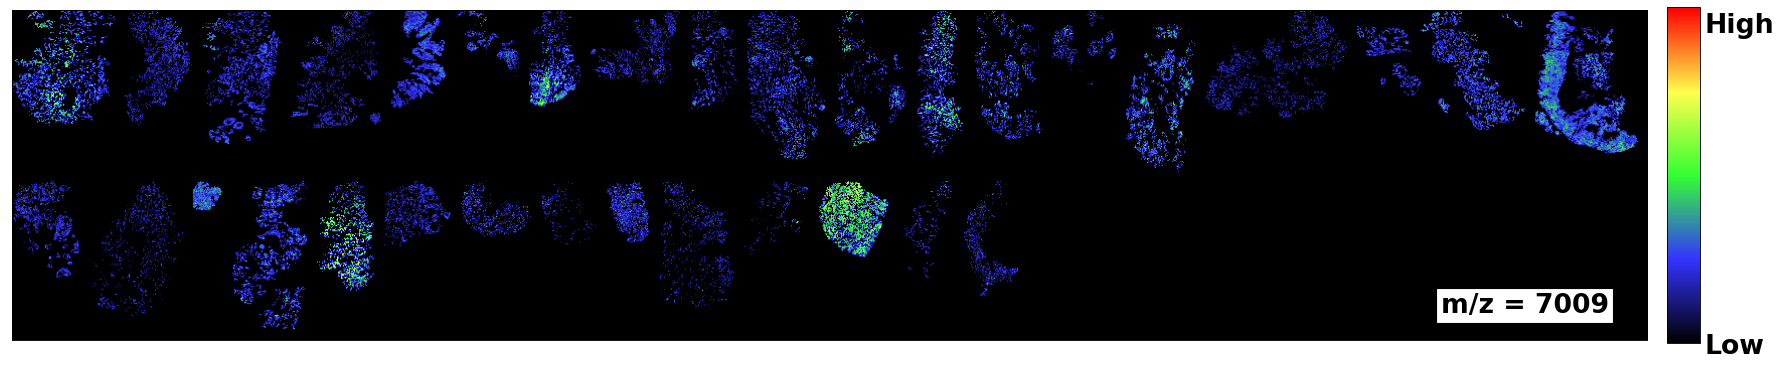

In [274]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


colorarray=["black",adjust_lightness("blue",1.2),adjust_lightness("lime",1.2),adjust_lightness("yellow",1.3),adjust_lightness("red",1)]
cmap = CreateColorMap_Continuous(len(colorarray)+1,colorarray)

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.imshow(protein_arr,cmap)
colorbar = plt.colorbar(aspect=10,shrink=0.9, pad=0.01)
max_tick = 0.016 # variable to be edited for max tick

colorbar.ax.tick_params(size=0)
colorbar.set_ticks([0,max_tick]) # Comment the colorbar lines and look at the tick values to find the max value tick to be edited
colorbar.ax.set_yticklabels(['Low','High'],weight='bold',fontsize=24) 
plt.text(1420,300, "{}{}".format("m/z = ", protein_ion) , fontsize = 24,fontweight="bold",bbox = dict(facecolor = 'white', alpha = 1))
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()


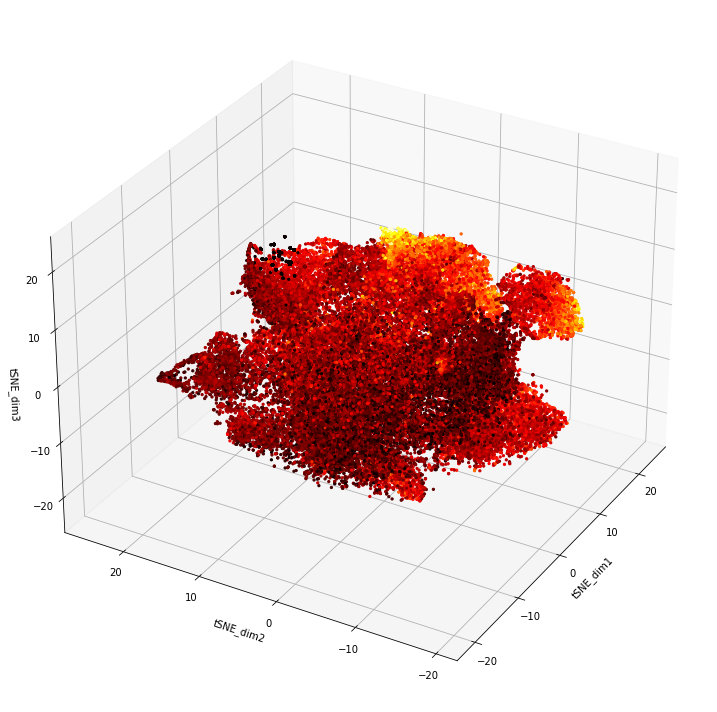

In [275]:
cmhot = plt.get_cmap("hot") #name of cmap u want from matplotlib

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = sample_only_data[:,protein_index],
    cmap = cmhot,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')


# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()